In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
!pip install shap

In [16]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn-v0_8') # 이 위에 코드를 실행하면 여러 테마가 있으니 마음껏 바꾸셔도 됩니다.
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm
import xgboost as xgb
import catboost

from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


from dateutil import tz

import shap
import skimage


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.options.display.max_columns = 400
pd.set_option('display.max_colwidth', None)

<Figure size 1600x800 with 0 Axes>

In [38]:
path = '/content/drive/MyDrive/Colab Notebooks/model/4.24_land_modi(개별).csv'
df = pd.read_csv(path)
df

,Unnamed: 0,annual_inc,dti,installment,int_rate,loan_amnt,mort_acc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,pub_rec,pub_rec_bankruptcies,loan_status,emp_length_int,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,1,94000.0,17.41,822.95,14.47,35000.0,0.0,30.0,154.0,0.0,0.0,0.0,Current,2.0,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,110000.0,34.70,680.82,24.99,23200.0,2.0,126.0,277.0,0.0,0.0,0.0,Charged Off,10.0,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,35000.0,14.95,145.06,9.93,4500.0,0.0,127.0,265.0,1.0,0.0,0.0,Current,10.0,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,65000.0,17.74,494.55,7.07,16000.0,3.0,134.0,400.0,0.0,0.0,0.0,Charged Off,0.0,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,6,50000.0,6.99,146.10,10.42,4500.0,1.0,226.0,130.0,0.0,2.0,2.0,Fully Paid,5.0,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535702,1755290,33800.0,19.18,133.78,19.99,3600.0,1.0,151.0,36.0,0.0,0.0,0.0,Charged Off,7.0,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1535703,1755291,71000.0,23.92,583.89,6.68,19000.0,5.0,125.0,216.0,0.0,0.0,0.0,Fully Paid,4.0,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1535704,1755292,44000.0,12.85,329.65,14.33,9600.0,1.0,25.0,99.0,0.0,0.0,0.0,Fully Paid,9.0,2013,5,5,692.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1535705,1755293,67000.0,20.94,744.90,7.35,24000.0,2.0,54.0,151.0,1.0,0.0,0.0,Fully Paid,5.0,2018,2,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# 결측치 있나 확인
df.isnull().sum()

Unnamed: 0                    0
annual_inc                    0
dti                           0
installment                   0
int_rate                      0
loan_amnt                     0
mort_acc                      0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
num_accts_ever_120_pd         0
pub_rec                       0
pub_rec_bankruptcies          0
loan_status                   0
emp_length_int                0
issue_d_year                  0
issue_d_month                 0
grade_numeric                 0
fico_range_mean               0
home_ownership_MORTGAGE       0
home_ownership_NONE           0
home_ownership_OTHER          0
home_ownership_OWN            0
home_ownership_RENT           0
purpose_credit_card           0
purpose_debt_consolidation    0
purpose_educational           0
purpose_home_improvement      0
purpose_house                 0
purpose_major_purchase        0
purpose_medical               0
purpose_moving                0
purpose_

In [40]:
# 필요 없는 부분 제거
df.drop(columns = 'Unnamed: 0', inplace = True)

In [41]:
df

,annual_inc,dti,installment,int_rate,loan_amnt,mort_acc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,pub_rec,pub_rec_bankruptcies,loan_status,emp_length_int,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,94000.0,17.41,822.95,14.47,35000.0,0.0,30.0,154.0,0.0,0.0,0.0,Current,2.0,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,110000.0,34.70,680.82,24.99,23200.0,2.0,126.0,277.0,0.0,0.0,0.0,Charged Off,10.0,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35000.0,14.95,145.06,9.93,4500.0,0.0,127.0,265.0,1.0,0.0,0.0,Current,10.0,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,65000.0,17.74,494.55,7.07,16000.0,3.0,134.0,400.0,0.0,0.0,0.0,Charged Off,0.0,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000.0,6.99,146.10,10.42,4500.0,1.0,226.0,130.0,0.0,2.0,2.0,Fully Paid,5.0,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535702,33800.0,19.18,133.78,19.99,3600.0,1.0,151.0,36.0,0.0,0.0,0.0,Charged Off,7.0,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1535703,71000.0,23.92,583.89,6.68,19000.0,5.0,125.0,216.0,0.0,0.0,0.0,Fully Paid,4.0,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1535704,44000.0,12.85,329.65,14.33,9600.0,1.0,25.0,99.0,0.0,0.0,0.0,Fully Paid,9.0,2013,5,5,692.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1535705,67000.0,20.94,744.90,7.35,24000.0,2.0,54.0,151.0,1.0,0.0,0.0,Fully Paid,5.0,2018,2,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
not_deliq = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

1535707
1535707


In [43]:
df['target'] = target

In [44]:
# current와 issued를 제거
df = df[df['loan_status']!= 'Current']
df = df[df['loan_status']!= 'Issued']

In [45]:
df.drop(columns = 'loan_status', inplace = True)

In [46]:
x_data = list(df.columns)
x_data.remove('target')

In [47]:
len(x_data)

85

In [48]:
x_data

['annual_inc',
 'dti',
 'installment',
 'int_rate',
 'loan_amnt',
 'mort_acc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'num_accts_ever_120_pd',
 'pub_rec',
 'pub_rec_bankruptcies',
 'emp_length_int',
 'issue_d_year',
 'issue_d_month',
 'grade_numeric',
 'fico_range_mean',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 'addr_state_CT',
 'addr_state_DC',
 'addr_state_DE',
 'addr_state_FL',
 'addr_state_GA',
 'addr_state_HI',
 'addr_state_IA',
 'addr_state_ID',
 'addr_state_IL',
 'addr_state_IN

In [49]:
processing = ['annual_inc',
 'dti',
 'installment',
 'int_rate',
 'loan_amnt',
 'mort_acc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'num_accts_ever_120_pd',
 'pub_rec',
 'pub_rec_bankruptcies',
 'emp_length_int',
 'issue_d_year',
 'issue_d_month',
 'grade_numeric',
 'fico_range_mean',]

In [50]:
# robustscaler로 scale
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
scaled_data = scaler.fit_transform(df[processing])
df[processing] = scaled_data

# transformer = RobustScaler()
#transformer.fit(df[processing])

# df[processing] = transformer.transform(df[processing])

In [51]:
df

,annual_inc,dti,installment,int_rate,loan_amnt,mort_acc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,pub_rec,pub_rec_bankruptcies,emp_length_int,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,target
1,0.224850,1.980705,0.936573,2.474844,0.996476,0.231141,0.017188,1.025359,-0.368564,-0.349609,-0.354380,1.149812,0.267064,0.145594,-1.820623,-0.842308,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.092299,-0.034707,0.228351,-1.265699,0.182499,0.746972,0.171250,2.322880,-0.368564,-0.349609,-0.354380,-1.486162,0.809346,1.020026,1.327976,3.792426,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,-0.198015,-1.312164,-1.096498,-0.566435,-1.117604,-0.284691,1.942968,-0.525336,-0.368564,3.003199,5.013003,-0.168175,0.809346,-0.437360,0.540827,0.084638,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-0.127538,1.296226,0.801331,-0.656191,0.634708,-0.284691,0.460117,0.107601,3.380146,-0.349609,-0.354380,1.149812,-0.275217,0.728549,0.540827,-0.687817,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.136915,-0.917637,0.181281,1.009519,0.521656,0.746972,0.325313,0.276384,-0.368564,-0.349609,-0.354380,-0.168175,1.893909,-0.437360,-1.033473,1.166076,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535700,-0.127538,0.236233,0.866728,0.863404,1.369548,-0.284691,2.058515,-0.377651,-0.368564,-0.349609,-0.354380,-0.958967,-1.359781,-1.311791,-0.246323,-0.069853,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1535702,-0.312189,0.136413,-1.143340,1.431165,-1.219351,-0.284691,0.498633,-1.516937,-0.368564,-0.349609,-0.354380,0.359020,-0.817499,-1.020314,-1.820623,-0.996800,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1535703,-0.050012,0.699683,0.568033,-1.347106,0.521656,1.778634,-0.002070,0.381873,-0.368564,-0.349609,-0.354380,-0.431772,-0.275217,-0.728837,1.327976,1.166076,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [52]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [53]:
# train셋을 oversampling
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_resample(df_train[x_data], df_train['target'])

In [54]:
print(X_train.shape)
print(y_train.shape)

(1035054, 85)
(1035054,)


In [56]:
# val셋을 test셋으로 넣음
X_test = df_validation[x_data]
y_test = df_validation['target']

In [57]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(f1_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()


In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [59]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

xgboost = Train(XGBClassifier(n_estimators=100, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=100, max_depth=7, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=100, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:30

Prediction time: 
Execution Time: 00:00:01
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 517527, number of negative: 517527
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3978
[LightGBM] [Info] Number of data points in the train set: 1035054, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training time: 
Execution Time: 00:00:22

Prediction time: 
Execution Time: 00:00:02
Training time: 
Execution Time: 00:00:29

Prediction time: 
Execution Time: 00:00:00


In [60]:
models = [
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat)
]

In [61]:
# model = [xgboost, lgb, cat]
# threshold = np.linspace(25, 75,51)/100

In [62]:
# threshold

In [63]:
# # 테스트셋에 대한 예측 확률 가져오기
# y_pred_proba = xgboost.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# # 사용자가 정의한 임계값으로 예측을 바꾸기
# confusion_matrices = {}

# for cut in threshold:
#     y_pred = (y_pred_proba >= cut).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     # 딕셔너리에 저장
#     confusion_matrices[f"xgboost{cut}"] = cm

# for name, cm in confusion_matrices. items():
#     print(f"Confusion Matrix for {name}")
#     print (cm)
#     print()

In [64]:
# # 테스트셋에 대한 예측 확률 가져오기
# y_pred_proba = lgb.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# # 사용자가 정의한 임계값으로 예측을 바꾸기
# confusion_matrices = {}

# for cut in threshold:
#     y_pred = (y_pred_proba >= cut).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     # 딕셔너리에 저장
#     confusion_matrices[f"lgb{cut}"] = cm

# for name, cm in confusion_matrices. items():
#     print(f"Confusion Matrix for {name}")
#     print (cm)
#     print()

In [65]:
# # 테스트셋에 대한 예측 확률 가져오기
# y_pred_proba = cat.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# # 사용자가 정의한 임계값으로 예측을 바꾸기
# confusion_matrices = {}

# for cut in threshold:
#     y_pred = (y_pred_proba >= cut).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     # 딕셔너리에 저장
#     confusion_matrices[f"cat{cut}"] = cm

# for name, cm in confusion_matrices. items():
#     print(f"Confusion Matrix for {name}")
#     print (cm)
#     print()

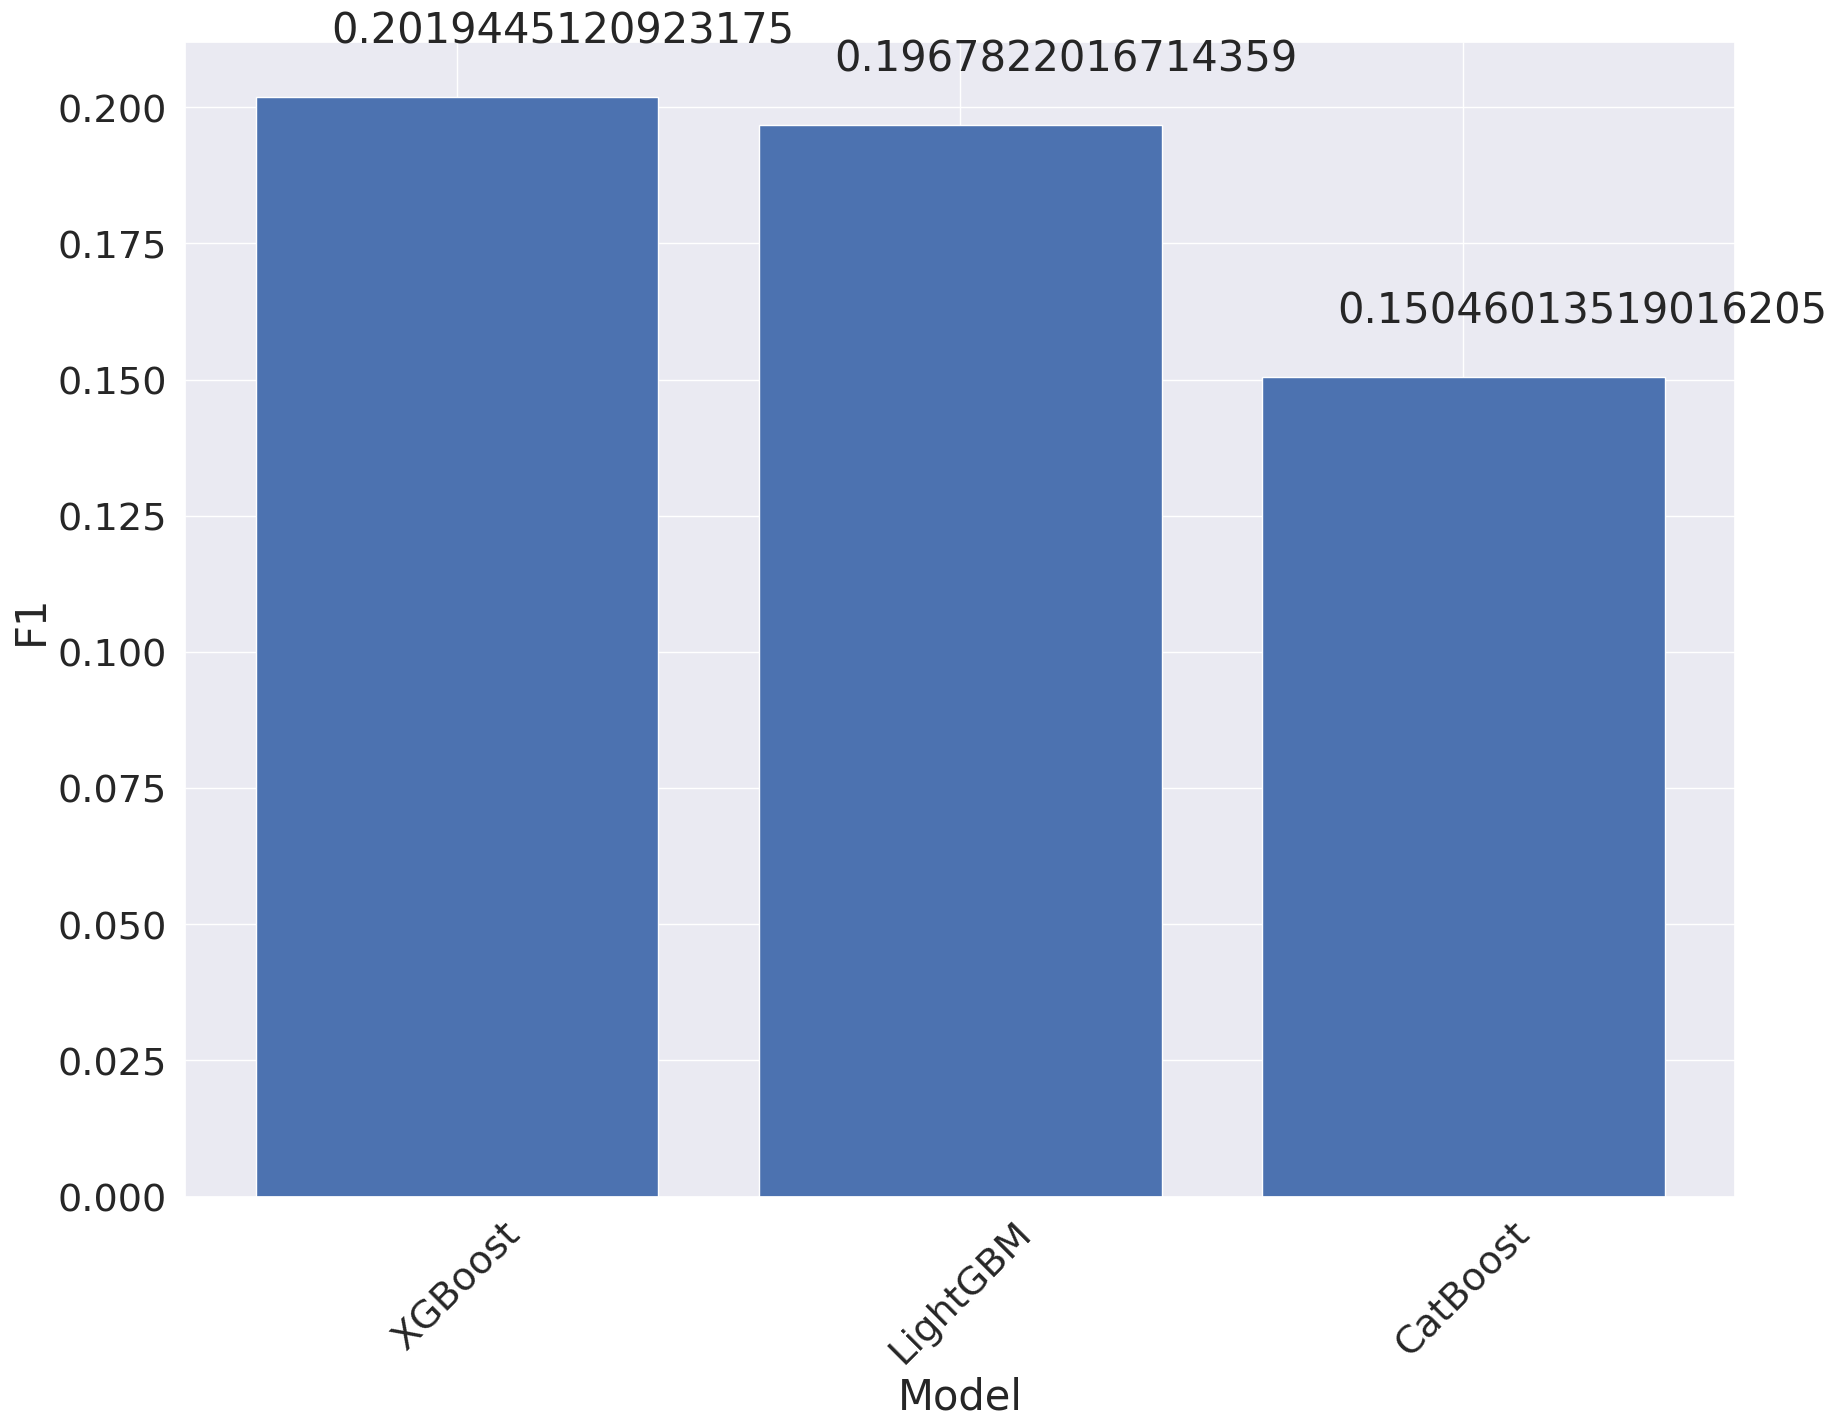

In [66]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'F1': scores })
model_scores.sort_values(by='F1',ascending=False,inplace=True)
plot_metric(model_scores, score='F1')

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgboost.predict(X_test)))
print(classification_report(y_test, lgb.predict(X_test)))
print(classification_report(y_test, cat.predict(X_test)))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89    172083
           1       0.49      0.13      0.20     42473

    accuracy                           0.80    214556
   macro avg       0.66      0.55      0.54    214556
weighted avg       0.75      0.80      0.75    214556

              precision    recall  f1-score   support

           0       0.82      0.97      0.89    172083
           1       0.50      0.12      0.20     42473

    accuracy                           0.80    214556
   macro avg       0.66      0.55      0.54    214556
weighted avg       0.76      0.80      0.75    214556

              precision    recall  f1-score   support

           0       0.81      0.98      0.89    172083
           1       0.56      0.09      0.15     42473

    accuracy                           0.81    214556
   macro avg       0.68      0.53      0.52    214556
weighted avg       0.76      0.81      0.74    214556



In [ ]:
# test 데이터 predict 구하기
# xgb
#xgboost.predict(df_test[x_data])
# lgb
#lgb.predict(df_test[x_data])
# cat
cat.predict(df_test[x_data])

array([0, 1, 1, ..., 0, 0, 1])

## Confusion matrix

In [ ]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[165763   6320]
 [ 37364   5109]]

Confusion Matrix for LightGBM
[[166317   5766]
 [ 37654   4819]]

Confusion Matrix for CatBoost
[[168226   3857]
 [ 38546   3927]]



각 연도별 데이터를 dict형태로 정리해서 각각 예측한 값을 confusion으로 비교

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_test['target'], xgboost.predict(df_test[x_data])))
print(classification_report(df_test['target'], lgb.predict(df_test[x_data])))
print(classification_report(df_test['target'], cat.predict(df_test[x_data])))


              precision    recall  f1-score   support

           0       0.82      0.96      0.88    172070
           1       0.45      0.12      0.19     42487

    accuracy                           0.80    214557
   macro avg       0.63      0.54      0.54    214557
weighted avg       0.74      0.80      0.75    214557

              precision    recall  f1-score   support

           0       0.82      0.97      0.88    172070
           1       0.46      0.11      0.18     42487

    accuracy                           0.80    214557
   macro avg       0.64      0.54      0.53    214557
weighted avg       0.74      0.80      0.75    214557

              precision    recall  f1-score   support

           0       0.81      0.98      0.89    172070
           1       0.50      0.09      0.15     42487

    accuracy                           0.80    214557
   macro avg       0.66      0.53      0.52    214557
weighted avg       0.75      0.80      0.74    214557



In [ ]:
year = list(df['issue_d_year'].unique())

In [ ]:
year

[2016,
 2017,
 2015,
 2019,
 2018,
 2014,
 2013,
 2020,
 2012,
 2008,
 2011,
 2010,
 2009,
 2007]

In [ ]:
year_dict = {}
for x in year:
    year_dict[x] = df[df['issue_d_year'] == x]


In [ ]:
year_dict[2019].drop('target', axis = 1)

,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,fico_range_high,fico_range_low,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
4,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,739.0,735.0,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,306.64,133.0,286.0,0.0,0.0,150000.0,23.00,699.0,695.0,12475.000000,5,16.40,12500.0,1.0,0.0,2019,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,443.49,160.0,515.0,0.0,0.0,48000.0,15.33,664.0,660.0,12750.000000,5,15.24,12750.0,0.0,3.0,2019,12,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,1256.97,60.0,77.0,1.0,1.0,140000.0,6.91,684.0,680.0,40000.000000,7,8.19,40000.0,2.0,0.0,2019,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79,240.27,238.0,164.0,0.0,0.0,46000.0,22.83,764.0,760.0,7000.000000,5,14.30,7000.0,0.0,0.0,2019,9,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071121,277.84,154.0,103.0,1.0,1.0,120000.0,10.15,694.0,690.0,8400.000000,6,11.71,8400.0,0.0,1.0,2019,10,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1071158,425.73,72.0,71.0,1.0,1.0,82000.0,15.76,669.0,665.0,13000.000000,6,11.02,13000.0,2.0,0.0,2019,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1071170,1256.97,121.0,201.0,0.0,0.0,85000.0,4.86,709.0,705.0,40000.000000,7,8.19,40000.0,5.0,0.0,2019,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1071179,648.40,83.0,85.0,1.0,1.0,57000.0,19.18,694.0,690.0,17950.000000,5,17.74,18000.0,0.0,0.0,2019,7,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(year_dict[2007].drop('target', axis = 1))
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(year_dict[2007]['target'], y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[210   2]
 [ 75  11]]

Confusion Matrix for LightGBM
[[212   0]
 [ 86   0]]

Confusion Matrix for CatBoost
[[208   4]
 [ 82   4]]



In [ ]:
for year in range(2007,2021):
    confusion_matrices = {}
    # 각 모델에 대한 전퓨전 매트릭스 상성
    for name, model in models:
        # 모델의 예측값 얻기
        y_pred = model.predict(year_dict[year].drop('target', axis = 1))
        # 컨퓨전 매트릭스 생성
        cm = confusion_matrix(year_dict[year]['target'], y_pred)
        # 딕셔너리에 저장
        confusion_matrices[name] = cm

    # 컨퓨전 매트릭스 출력
    for name, cm in confusion_matrices. items():
        print(f"{year} Confusion Matrix for {name}")
        print (cm)
        print()

2007 Confusion Matrix for XGBoost
[[210   2]
 [ 75  11]]

2007 Confusion Matrix for LightGBM
[[212   0]
 [ 86   0]]

2007 Confusion Matrix for CatBoost
[[208   4]
 [ 82   4]]

2008 Confusion Matrix for XGBoost
[[1123    2]
 [ 288    3]]

2008 Confusion Matrix for LightGBM
[[1125    0]
 [ 291    0]]

2008 Confusion Matrix for CatBoost
[[1125    0]
 [ 291    0]]

2009 Confusion Matrix for XGBoost
[[2634    0]
 [ 415    3]]

2009 Confusion Matrix for LightGBM
[[2634    0]
 [ 418    0]]

2009 Confusion Matrix for CatBoost
[[2634    0]
 [ 418    0]]

2010 Confusion Matrix for XGBoost
[[6124    5]
 [ 971    4]]

2010 Confusion Matrix for LightGBM
[[6129    0]
 [ 974    1]]

2010 Confusion Matrix for CatBoost
[[6127    2]
 [ 973    2]]

2011 Confusion Matrix for XGBoost
[[10444    10]
 [ 1815    22]]

2011 Confusion Matrix for LightGBM
[[10453     1]
 [ 1835     2]]

2011 Confusion Matrix for CatBoost
[[10451     3]
 [ 1829     8]]

2012 Confusion Matrix for XGBoost
[[26544    25]
 [ 5136    

## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

In [ ]:
explainer = shap.TreeExplainer(cat) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)